In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import sys
import os
import itertools as _it
import matplotlib.cm as plt_cm
import matplotlib.colors as plt_col
import sklearn.datasets as ds
import sklearn
sys.path.append("C:/ProgramData/Anaconda2/envs/ListManagement/Lib/site-packages")
from PythonUtilities.PyDBA.pydba import PyDBA, pd
from PythonUtilities.LoggingUtility import Logging
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import Imputer
from sklearn.feature_selection import VarianceThreshold
from fancyimpute import KNN
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder


log = Logging(name='SmartListGenerator', abbr='SLG', dir_=os.path.expanduser('~\\Documents\\Logs\\SLG')).logger
dba = PyDBA(log=log)
con = dba.init_new_connection('DPHL-PROPSCORE', 'FSHeartbeat')
os.sys.path.append('C://Users//_cmattson//Documents//GitHub//ppca//src')
import pca

C:\ProgramData\Anaconda2\envs\ListManagement\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
PyDBA BOOTING UP.
mssql+pymssql://DPHL-PROPSCORE/FSHeartbeat database exists.
New DPHL-PROPSCORE.FSHeartbeat connection successfully established.


In [3]:
def categorizer(df):
    if df.nunique(dropna = True) > 20:
        df = df.astype('category').cat.codes
        return df
    else:
        dummies = pd.get_dummies(df)
        #df = df.merge(dummies, how = 'left', left_on=df.index, right_on = dummies.index)
        return dummies


In [4]:
#fix data
le = preprocessing.LabelEncoder()
df = dba.read_df('InvestorPersonaData', con)
df = pd.DataFrame(df)
df_inter = {}
df_final = {}
data_fix = []
c_list= list(df.columns.values)
#ex_list = ['Full Name', 'Branch Type', 'Success Likelihood', 'AUM Source', 'Title Categories', 'State', 'SellsRetirementPlanProducts', 'PriorFirm1_Name', 'PriorFirm1_NumberOfYears', 'PriorFirm2_Name', 'PriorFirm2_NumberOfYears', 'PriorFirm3_Name', 'PriorFirm3_NumberOfYears', 'PriorFirm4_Name', 'PriorFirm4_NumberOfYears', 'PriorFirm5_Name', 'PriorFirm5_NumberOfYears', 'RegulatoryDisclosures', 'AUMSelfReported', 'Address 1', 'Address 2', 'City', 'ZipCode', 'DateOfBirth_Full','PriorFirm1_FirmCRD', 'PriorFirm2_FirmCRD', 'PriorFirm3_FirmCRD', 'PriorFirm4_FirmCRD', 'PriorFirm5_FirmCRD']
for column in c_list:
    #if column not in ex_list: 
    df_inter[column]= (df[column])
for column in df_inter:
    if type(df_inter[column][1])== 'str':
        df_final[column] = {**categorizer(df_inter[column]), **df_final}
    else:
        df_final[column] = df_inter[column]

In [ ]:
def rs_categorizer(df):
    df = df.astype('category').cat.codes
    return df

# feature engineering
df_rs = df#.drop(ex_list, axis=1)
for col in df_rs.columns.tolist():
#     print('engineering on {0}, of dtype {1}'.format(col,df_rs[col].dtype))
    if df_rs[col].dtype == 'object':
#         if df_rs[col].nunique(dropna = True) > 7:
        df_rs[col] = rs_categorizer(df_rs[col])
#         else:
#             dummies = pd.get_dummies(df_rs[col])
#             df_rs = pd.merge(df_rs, dummies, how = 'left', left_on=df.index, right_on = dummies.index)
#             df_rs.drop('key_0', axis=1, inplace=True)
        
#        df_rs[col].fillna(-1, inplace=True)
#    elif df_rs[col].dtype in ['int', 'float']:
#        df_rs[col].fillna(df_rs[col].mean(), inplace=True)
        
    elif df_rs[col].dtype == 'datetime64[ns]':
        df_rs[col] = pd.to_datetime(df_rs[col])
        df_rs[col] = (pd.to_datetime('now') -  df_rs[col]).dt.days / 365
#        df_rs[col].fillna(df_rs[col].mean(), inplace=True)

# KNN

In [ ]:
df_knn = KNN(k=3).fit_transform(df_rs)

In [ ]:
def plot_scatter(x, classes, ax=None):
    ax = plt.gca() if ax is None else ax
    cmap = plt_cm.jet
    norm = plt_col.Normalize(vmin=np.min(classes), vmax=np.max(classes))
    mapper = plt_cm.ScalarMappable(cmap=cmap, norm=norm)
    colors = mapper.to_rgba(classes)
    ax.scatter(x[0, :], x[1, :], color=colors, s=20)

def plot_digits(x, classes, ax=None):
    xx = x[0, :]
    yy = x[1, :]
    width = np.max(xx) - np.min(xx)
    height = np.max(yy) - np.min(yy)
    ax = plt.gca() if ax is None else ax
    ax.set_xlim([np.min(xx) - 0.1 * width, np.max(xx) + 0.1 * width])
    ax.set_ylim([np.min(yy) - 0.1 * height, np.max(yy) + 0.1 * height])
    cmap = plt_cm.jet
    norm = plt_col.Normalize(vmin=0, vmax=9)
    mapper = plt_cm.ScalarMappable(cmap=cmap, norm=norm)
    colors = mapper.to_rgba(range(10))
    for x1, x2, digit in zip(xx, yy, classes):
        ax.text(x1, x2, digit, color=colors[int(digit)])
         
def plot_mse(mse):
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(mse, linewidth=2, marker='s',markersize=5, markerfacecolor='red')
    ax.grid()
    ax.set_xlabel('Iteration')
    ax.set_ylabel('MSE')
    
def plot_grid(n, ncols=4, size=(5, 5)):
    nrows = int(np.ceil(n/float(ncols)))
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(size[0]*ncols, size[1]*nrows))
    ax = ax.ravel()
    return [fig, ax]

def plot_bppca(y, y_classes, maxit=74, *args, **kwargs):
    np.random.seed(0)
    bppca = pca.bppca.BPPCA(y, *args, **kwargs)
        
    fig, ax = plot_grid(maxit + 1)
    mse = [bppca.mse()]
    plot_scatter(bppca.transform(), y_classes, ax[0])
    for i in range(maxit):
        bppca.update()
        mse.append(bppca.mse())
        j = i + 1
        plot_scatter(bppca.transform(), y_classes, ax[j])
        ax[j].set_title('Iteration {}'.format(j))
    plot_mse(mse)
    return bppca

def replot(bppca, y_classes, maxit=74):
    np.random.seed(0)
    fig, ax = plot_grid(maxit + 1)
    mse = [bppca.mse()]
    plot_scatter(bppca.transform(), y_classes, ax[0])
    for i in range(maxit):
        bppca.update()
        mse.append(bppca.mse())
        j = i + 1
        plot_scatter(bppca.transform(), y_classes, ax[j])
        ax[j].set_title('Iteration {}'.format(j))
    plot_mse(mse)
    return bppca

# PPCA

In [ ]:
df_y = np.transpose(df_knn)

target = np.array([1,2,3,4,5,6,7,8])
target_names = np.array(['cluster 1','cluster 2', 'cluster 3', 'cluster 4', 'cluster 5', 'cluster 6', 'cluster 7', 'cluster 8'])
df_ds = sklearn.datasets.base.Bunch(data=df_y, target=target, target_names=target_names, feature_names= c_list)

In [ ]:
ppca = pca.ppca.PPCA()
ppca.fit(df_y)
target = np.array([1,2,3,4,5,6,7,8])

In [7]:
from sklearn.cluster import AffinityPropagation
clustering = AffinityPropagation().fit(df_y)

NameError: name 'df_y' is not defined

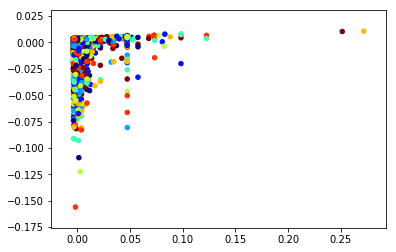

In [18]:
plot_scatter(ppca.transform(), target)

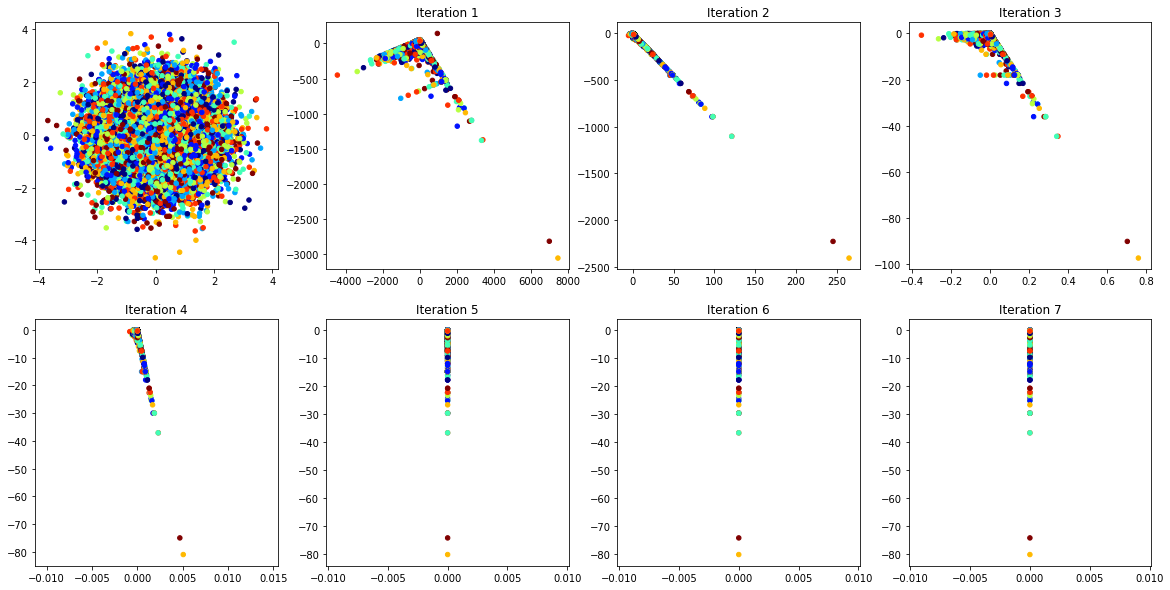

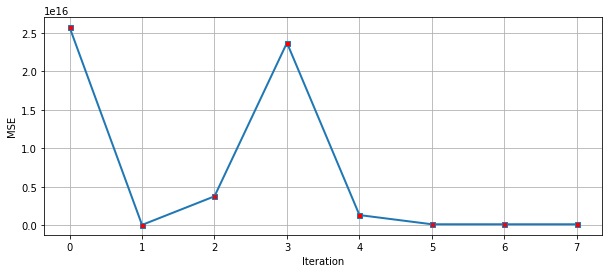

In [19]:
bppca = plot_bppca(df_y, target)

In [39]:
x,y = enumerate(bppca.transform())

In [46]:
len(x[1])


18911

In [47]:
len(y[1])

18911

In [49]:
bppca.transform()

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.77098177, -0.70153181, -2.09991811, ..., -0.30873002,
        -0.27938191, -0.35078783]])